1. for sanity check
   - use half moon set at three settings
   - linearly sperable, non linearly sperable
   - create basic mlp, cnn and rbfs for each type
2. need decision boundary for sanity check, and image saver for mnists
4. for mnists need to create a hyperparam set for mlp, cnn and rbfs
   - rbfs have three params, x, y and color val for images
   - rbf hyper params -- clustering algorithms, rbf width, covariance calc
   - mlp -- distribution between width and depth, online and minibatch and batch, 
   - cnn -- stride and pooling, activation funcs, and dialation
5. for fashion mnist, use optimal settings, and different hyperparam sets

In [1]:
import os
import itertools
import json
import pickle

import torch
import torch.utils.tensorboard as tb
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.profiler import profile, ProfilerActivity, record_function

import display
import models
import general_torch as gt

In [2]:
# init invariants

device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.float16 if device == "cuda" else torch.float

# df = display.initialize_class_dataframe()
experiment_directory = f'experiments/troubleshoot_dump'

invariable_dict = {
  'data_path': 'iris_tensor_dict.pt',
  'exp_file': experiment_directory,
  'model_type': 'classification',
  'device': device,
  'data_type': dtype,
  'run': None,
  'model': 'mlp0',
  'init_num': '0',
  'optim': 'sgd',
  'optim_dict': {'lr': 0.1, 'momentum': 0.4},
  'error_f': 'bce',
  'stop_dict': {'criteria': 'epoch', 'stop_val': 100, 'max_epochs': 100},
  'dl_dict': {'batch_size': 1, 'shuffle': True},
  'seed': 42,
  'hparams': None,
}

cwd = os.getcwd()
exp_dir = os.path.join(cwd, experiment_directory)

In [3]:
# load in data

file_tensor = os.path.join(cwd, f'data/{invariable_dict["data_path"]}')

dict_tensor = torch.load(file_tensor)

train_data = dict_tensor['train_data'].to(device).to(dtype)
train_label = dict_tensor['train_label'].to(device).to(dtype)

valid_data = dict_tensor['valid_data'].to(device).to(dtype)
valid_label = dict_tensor['valid_label'].to(device).to(dtype)

test_data = dict_tensor['test_data'].to(device).to(dtype)
test_label = dict_tensor['test_label'].to(device).to(dtype)

# todo in future init this in data init
class_labels = [0, 1, 2]

In [4]:
# init data class and data sets

class Data(Dataset):
  def __init__(self, train, label):
    self.data = train
    self.label = label

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return self.data[idx], self.label[idx]


train_set = Data(train_data, train_label)
valid_set = Data(valid_data, valid_label)
test_set = Data(test_data, test_label)

In [5]:
# use itertools to generate hparam dictionaries

hparam1 = {'optim_dict': [{'lr': 0.1, 'momentum': 0.4}, {'lr'
                                                         : 0.01, 'momentum': 0.4}, {'lr': 0.001, 'momentum': 0.4}]}
hparam2 = {'dl_dict': [{'batch_size': 1, 'shuffle': True}, {'batch_size': 1, 'shuffle': True},
                       {'batch_size': 1, 'shuffle': True}]}
hparam3 = {'error_f': ['ce', 'bce', 'bcel']}

combined_hparams = [
  {'optim_dict': opt, 'dl_dict': dl, 'error_f': err}
  for opt, dl, err in itertools.product(hparam1['optim_dict'], hparam2['dl_dict'], hparam3['error_f'])
]

In [6]:
# using combined hparams and the invariable base dict, create
# run dict

run_dict = {}
for run, hparam_dict in enumerate(combined_hparams):
  new_dict = {**invariable_dict, **hparam_dict}
  new_dict['hparams'] = hparam_dict
  new_dict['run'] = run
  dict_pair = {run: new_dict}
  run_dict.update(dict_pair)


In [7]:
# todo in main script, replace this with an encapsulating loop, right now keep it simple
# init loop variables

exp = run_dict[2]

# init log path for this run
log = os.path.join(exp_dir, f"run{exp['run']}")

# always start by resetting seeds before initializing anythin  g
gt.init_seeds(exp['seed'], exp['device'])

# prep dataloader, use kwargs to init

train_loader = DataLoader(train_set, **exp['dl_dict'])
valid_loader = DataLoader(valid_set, **exp['dl_dict'])
test_loader = DataLoader(test_set, **exp['dl_dict'])

# build model / load state dict / load whole model / explicitly init param weights

model_path = f"{exp['model']}_{exp['init_num']}"

model = models.get_model(exp['model'])()
model.load_state_dict(models.load_init_model(model_path))
model.to(exp['data_type'])
model.to(exp['device'])

optim = gt.get_optim(exp['optim'])(model.parameters(), **exp['optim_dict'])
error = gt.get_error(exp['error_f'])()

profile_model = models.get_model(exp['model'])()
profile_model.load_state_dict(models.load_init_model(model_path))
profile_model.to(exp['data_type'])
profile_model.to(exp['device'])
profile_train_loader = DataLoader(train_set, **exp['dl_dict'])

# writer doesnt like interior dicts, get rid of them in hparams

format_hparams = {**exp['hparams']}

for key, value in format_hparams.items():
  if isinstance(value, dict):
    format_hparams[key] = json.dumps(value)

# init tensorboard writer
train_writer = tb.writer.SummaryWriter(log_dir=log)
test_writer = tb.writer.SummaryWriter(log_dir=os.path.join(log, 'test'))

In [8]:
# check for runtime errors / init predictions should be part of data collection loop
'''for i in model.parameters():
    print(i.dtype)
    break
print(test_data.dtype)'''

'''with torch.inference_mode():
  for batch_idx, (data, target) in enumerate(train_loader):
    model(test_data)'''

'with torch.inference_mode():\n  for batch_idx, (data, target) in enumerate(train_loader):\n    model(test_data)'

In [9]:
# profile model

with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
             schedule=torch.profiler.schedule(wait=5, warmup=4, active=1, repeat=1),
             on_trace_ready=torch.profiler.tensorboard_trace_handler(os.path.join(log, 'model_profiles')),
             record_shapes=True,
             with_stack=True,
             profile_memory=True) as prof:
  with record_function('training'):
    for batch_idx, (data, target) in enumerate(train_loader):
      pred = model(data)
      loss = error(pred, target)
      optim.zero_grad()
      loss.backward()
      optim.step()
      prof.step()
      if batch_idx == 9:
        break

  with record_function('inference'):
    for batch_idx, (data, target) in enumerate(test_loader):
      model(data)
      prof.step()
      if batch_idx == 9:
        train_writer.add_graph(model, data)
        break


C:\tools\Anaconda3\envs\mynn\Lib\site-packages\torch\autograd\profiler.py:255: UserWarning: CUDA is not available, disabling CUDA profiling
  warn("CUDA is not available, disabling CUDA profiling")


In [10]:
# init test predictions, to test overall improvement, only needed if model reuse

'''with torch.inference_mode():
    pred_list = []
    target_list = []
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):

        preds = model(data)
        loss = error(preds, target)
        pred_list.append(preds)
        target_list.append(target)
        total += loss
    avg_error = total / len(test_data)
    gt.write_test_info(exp, train_writer, target_list, pred_l
ist, avg_error)'''

'with torch.inference_mode():\n    pred_list = []\n    target_list = []\n    total = 0\n    for batch_idx, (data, target) in enumerate(train_loader):\n\n        preds = model(data)\n        loss = error(preds, target)\n        pred_list.append(preds)\n        target_list.append(target)\n        total += loss\n    avg_error = total / len(test_data)\n    gt.write_test_info(exp, train_writer, target_list, pred_l\nist, avg_error)'

In [11]:
# modify hyperparams, only for model reuse

'''modify_hyper = False
if modify_hyper:
    epochs = 10
    optim = torch.optim.SGD(model.parameters(), lr=0.001, mom
entum=0.4)
    error = torch.nn.MSELoss()'''

'modify_hyper = False\nif modify_hyper:\n    epochs = 10\n    optim = torch.optim.SGD(model.parameters(), lr=0.001, mom\nentum=0.4)\n    error = torch.nn.MSELoss()'

In [12]:
# for train and valid, log every epoch

error_last = None
for epoch in range(exp['stop_dict']['max_epochs']):
  model.train()
  total = 0
  target_list = []
  pred_list = []
  for batch_idx, (data, target) in enumerate(train_loader):
    pred = model(data)
    loss = error(pred, target)
    optim.zero_grad()
    loss.backward()
    optim.step()
    total += loss
    target_list.append(target)
    pred_list.append(pred)
  avg_error = total / len(train_data)
  display.write_classification_train_info(train_writer, model, target_list, pred_list, avg_error, 'train', epoch)

  model.eval()
  error_new = None
  total = 0
  target_list = []
  pred_list = []
  for batch_idx, (data, target) in enumerate(valid_loader):
    pred = model(data)
    error_new = error(pred, target)
    total += error_new
    target_list.append(target)
    pred_list.append(pred)
    avg_error = total / len(valid_data)
  display.write_classification_train_info(train_writer, model, target_list, pred_list, avg_error, 'valid', epoch)

  if exp['stop_dict']['criteria'] == 'error_change':
    if error_last is not None and error_new / error_last < exp['stop_val']:
      break
    else:
      error_last = error_new


In [13]:
# run final inference

with torch.inference_mode():
  pred_tensor_list = []
  target_tensor_list = []
  total = 0
  for batch_idx, (data, target) in enumerate(train_loader):
    preds = model(data)
    loss = error(preds, target)
    pred_tensor_list.append(preds)
    target_tensor_list.append(target)
    total += loss
  avg_error = total / len(test_data)

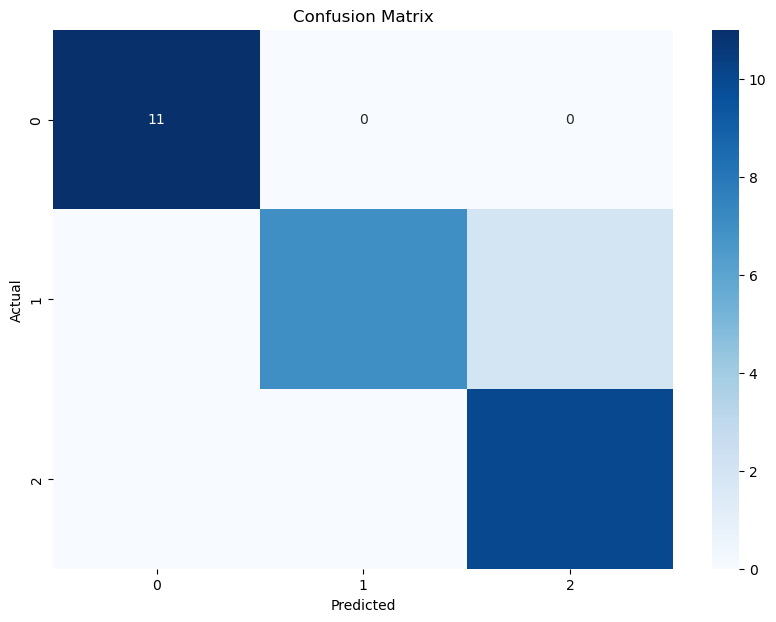

In [14]:
# convert tensors to lists

t = torch.stack(target_tensor_list, dim=0).squeeze()
p = torch.stack(pred_tensor_list, dim=0).squeeze()
target_tensor = torch.argmax(t, dim=1)
pred_tensor = torch.argmax(p, dim=1)
target_list = target_tensor.tolist()
pred_list = pred_tensor.tolist()
cm = display.plot_multiclass_confusion_matrix(target_list, pred_list, class_labels)


In [15]:
# do final tensorboard run write
# save preds, labels and state dict
# write test info into db

file_dir = {'preds': pred_list, 'lables': target_list,
            'state_dict': model.state_dict(), }
filename = os.path.join(log, 'model_info.pkl')

with open(filename, "wb") as file:
  pickle.dump(file_dir, file)

train_writer.add_figure('test/confusion_matrix', cm)
display.write_classification_test_info(test_writer, format_hparams, target_list, pred_list, avg_error)
# train_writer.add_pr_curve('test/precision_recall_curve', target_tensor, pred_tensor, 0)
train_writer.close()
test_writer.close()